# <span style="color:turquoise">Text classification with pytorch</span>


An example of using natural language processing for sentiment analysis. <br> Building a binary classifier of movie reviews that will predict if a review is positive or negative.




__Dataset:__ IMDB movie reviews from Kaggle<br>
__Model:__ LSTM


### <span style="color:teal">Todo:</span>

- ~~Read dataset~~
- ~~Preprocess text~~
- ~~Split into train, validation, and test sets~~
- ~~Convert text to indices and add paddings~~
- ~~Make model~~
- ~~Make training function~~
- ~~Make evaluation function~~
- ~~Train~~
- Evaluate on test set
- Run inference

In [1]:
import csv
import random
import numpy as np
from collections import Counter

from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
import re

import torch
import torch.nn as nn

import matplotlib.pyplot as plt
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


## <span style="color:teal">Read the data and split it into training, cross-validation, and test sets</span>

In [2]:
class Reviews():
    
    def __init__(self):
        self.train = {}
        self.val = {}
        self.test = {}
        self.LABELS = {"positive":1, "negative": 0}
        self.COUNT = {"positive": 0, "negative": 0}
    
    
    def read_data(self):
        
        dataset = []
        
        with open ("IMDB_Dataset.csv", newline='') as f:
            datareader = csv.reader(f, delimiter=',')
            next(datareader, None)

            for row in datareader:
                dataset.append([row[0], self.LABELS[row[1]]])
                self.COUNT[row[1]] += 1
            
            random.shuffle(dataset)
                
        return dataset




    def split_dataset(self,
                      dataset,
                      split=[int(50000*0.6), int(50000*0.2), int(50000*0.2)]):
        
        train, val, test = torch.utils.data.random_split(dataset,
                                               split,
                                               generator=torch.Generator().manual_seed(43))
          
            
        return train, val, test

In [3]:
rev = Reviews()
data = rev.read_data()
pos_count = rev.COUNT["positive"]
neg_count = rev.COUNT["negative"]


In [4]:
print(data[10])

['Gloria Victor and Dolores Reed in space girl costumes. That said, I could watch Gloria and Dolores walk around the space ship for about an hour or so.', 0]


In [5]:
train, val, test = rev.split_dataset(data)
print(train[10])

["Released on DVD in the UK as Axe, The Choke is a teen slasher that fails in pretty much every department: the story is almost non-existent, resulting in a film which comprises mostly of people wandering around a dark building; with the exception of two characters (who are quite obviously destined to be the film's survivors), everyone is thoroughly objectionable, meaning that the viewer couldn't care less when they get slaughtered; the deaths aren't gory enough (unless a brief shot of a pound of minced beef covered in fake blood turns your stomach); and the gratuitous sex scene features next to no nudity (an unforgivable mistake to make in a slasher flick!). The wafer-thin plot sees members of a punk band locked inside what appears to be the world's largest nightclub (there are endless abandoned corridors and rooms, unlike any club I've ever seen) where they are picked off by an unseen assailant. For a low budget effort, the production values are okay, and the cast are all seem to be 

In [6]:
print(len(train), len(val), len(test))

30000 10000 10000


In [7]:
def split_x_and_y(data):
    x = []
    y = []
    for review, label in data:
        x.append(review)
        y.append(label)
    return x, np.array(y)

In [8]:
train_x_raw, train_y = split_x_and_y(train)
val_x_raw, val_y = split_x_and_y(val)
test_x_raw, test_y = split_x_and_y(test)


print(len(train_x_raw), len(train_y))
print(train_x_raw[50], train_y[50])

30000 30000
As an aging rocker, this movie mentions Heep and Quo - my 2 favourite bands ever - but with the incredible cast (everyone) - and the fantastic storyline - I just love this piece of creative genius. I cannot recommend it more highly - and Mick Jones added so much (Foreigner lead and primary songwriter along with the greatest rock singer ever - Lou Gramm) - I have watched this great work more than 10 times- Bill Nighy - what a voice - and Jimmy Nail - talent oozes from every pore - then Astrid.... and Karen..... what more could an aging rocker ask for!! 10/10 - bloody brilliant. Alastair, Perth, Western Oz, Originally from Windsor, England. 1


## <span style="color:teal">Preprocess text</span>

In [9]:
def preprocess(review,
               remove_stopwords=False, 
               remove_html=True, 
               remove_punct=False, 
               lowercase=False, 
               lemmatize=False,
               maxlen=128):
    
    review = re.sub(r"\'", "'", review)
    review = re.sub(r"\x96", "-", review)
    
    if remove_html:
        review = re.sub(r'<.*>', ' ', review)
    
    review = word_tokenize(review)
        
    if remove_stopwords:
        stop_words = set(stopwords.words("english"))
        review = [w for w in review if w not in stop_words]
        
    if remove_punct:
        contractions = ["'ll", "'s", "n't", "'d", "'m", "'ve", "'re"]
        review = [w for w in review if w.isalnum() or w in contractions]
    
    if lowercase:
        review = [w.lower() for w in review]
        
    if lemmatize:
        lemmatizer = WordNetLemmatizer()
        review = [lemmatizer.lemmatize(w) for w in review]
    
    
    return review[:maxlen]
    


In [10]:
train_words = [preprocess(review, 
                      lowercase=True, 
                      remove_punct=True,
                      remove_stopwords=True
                     ) 
           for review in train_x_raw]

val_words = [preprocess(review, 
                    lowercase=True, 
                    remove_punct=True,
                    remove_stopwords=True
                   ) 
         for review in val_x_raw]

In [11]:
print(train_words[9592], '\n', val_words[3029])
print(len(train_words[9592]), '\n', len(val_words[3029]))

['the', 'story', 'quite', 'original', 'movie', 'kinda', 'slow', 'building', 'point', 'steal', 'cars', 'its', 'kinda', 'nice', 'though', 'watch', 'prepare', 'stealing', 'actual', 'stealing', "'ve", 'picture', 'however', 'stunt', 'work', 'movie', 'excellent', 'definetly', 'movie', 'have', 'see'] 
 ['zombie', 'bloodbath', 'movie', 'made', 'zombie', 'fans', 'zombie', 'fans', 'true', 'love', 'horror', 'genre', 'as', 'i', 'understand', 'commentary', 'things', 'i', 'read', 'made', 'huge', 'midwest', 'flood', '1993', 'half', 'missouri', 'underwater', 'buildings', 'water', 'cars', 'houses', 'underwater', 'one', 'article', 'said', 'zombies', 'crew', 'movie', 'would', 'help', 'sandbag', 'river', 'shooting', 'day', 'the', 'fact', 'movie', 'got', 'made', 'miracle', 'it', 'like', 'huge', 'mashing', 'every', 'zombie', 'movie', 'ever', 'made', 'put', 'troma', 'filter', 'it', 'party', 'movie', 'enjoy', 'friends', 'like', 'loads', 'splatter', 'goofy', 'characters', 'and', 'fast', 'paced', 'energetic', '

In [12]:
print(len(train_words))

30000


## <span style="color:teal">Convert text to indices and add paddings</span>

In [13]:
def make_vocabulary(preprocessed_data, 
                    vocab_size=10000,
                    pad_token='<PAD>',
                    unk_token='<UNK>'):
    
    # Create a vocabulary list of a given size
    freqs = {}
    for review in preprocessed_data:
        for word in review:
            freqs[word] = freqs.get(word, 0) + 1
            
    freqs_list = Counter(freqs).most_common(vocab_size)
    
    assert len(freqs_list) == vocab_size
    
    # Create word-index mappings
    vocab_list = [pair[0] for pair in freqs_list]
    word2ind = {word : i+2 for i, word in enumerate(vocab_list)}
    ind2word = {i+2 : word for i, word in enumerate(vocab_list)}
    
    # Prepend the pad token
    word2ind[pad_token] = 0
    ind2word[0] = pad_token
    
    # Prepend the 'unknown' token
    word2ind[unk_token] = 1
    ind2word[1] = unk_token
    
    assert len(word2ind) == len(ind2word)

    
    return word2ind, ind2word
  
    

In [14]:
word2ind, ind2word = make_vocabulary(train_words)

print(len(word2ind), len(ind2word))
print(word2ind['i'], word2ind['awful'])
print(ind2word[6700], ind2word[7893])

10002 10002
2 235
tilly lean


In [15]:
del train_x_raw, val_x_raw

In [16]:
print(np.max([len(x) for x in train_words]))
print(np.mean([len(x) for x in train_words]))

print(np.max([len(x) for x in val_words]))
print(np.mean([len(x) for x in val_words]))

128
71.508
128
70.8432


In [17]:
def make_padded_inputs(preprocessed_data, 
                       vocab, 
                       padded_length=64,
                       pad_token='<PAD>',
                       unk_token='<UNK>'
                      ):
    
    num_lines = len(preprocessed_data)
    pad = vocab[pad_token]
    
    inputs = np.full((num_lines, padded_length), pad)
    
    for i, review in enumerate(preprocessed_data):
        start_position = padded_length - len(review)
        for j, word in enumerate(review):
            inputs[i, (start_position + j)] = vocab.get(word, vocab[unk_token])
            
    return inputs
            

In [18]:
train_x = make_padded_inputs(train_words, word2ind)
val_x = make_padded_inputs(val_words, word2ind)


print(f"""Training example at indices 5 and 6:\n{train_words[5:7]}\n
    Converted to indices:\n{train_x[5:7, :]}\n""")

print(len(train_words[5]), np.count_nonzero(train_x[5]))

assert (len(train_words[5]) == np.count_nonzero(train_x[5])) or (64 == np.count_nonzero(train_x[5]))

Training example at indices 5 and 6:
[['written', 'produced', 'directed', 'charlie', 'chaplin', 'great', 'actor', "'s", 'propaganda', 'piece', 'skewering', 'adolf', 'hitler', 'this', 'good', 'movie', 'well', 'worth', 'watching'], ['this', 'te', 'cartoon', 'instead', 'country', 'cousin', 'visually', 'much', 'entertaining', 'memorable', 'worth', 'watching', 'music', 'alone', 'although', 'elements', 'undoubtably', 'bruise', 'sensibilities', 'days', 'cartoon', 'given', 'bit', 'perspective', 'it', "'s", 'sixty', 'years', 'old', 'cartoon', 'i', "'m", 'disabled', 'i', 'folks', 'look', 'things', 'like', 'cartoon', 'take', 'umbrage', 'i', 'would', 'long', 'since', 'curled', 'fetal', 'position', 'faded', 'away', 'sometimes', 'need', 'lighten', 'put', 'head', 'back', 'float', 'caricatures', 'celebrities', 'cartoons', 'common', '1930s', '1940s', 'almost', 'never', 'terribly', 'flattering', 'bing', 'crosby', 'reportedly', 'hated', 'used', 'one', 'occasion', 'sigh']]

    Converted to indices:
[[   

## <span style="color:teal">Load data into torch</span>

In [19]:
train_dataset = torch.utils.data.TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
val_dataset = torch.utils.data.TensorDataset(torch.from_numpy(val_x), torch.from_numpy(val_y))

In [20]:
batch_size = 64

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)

In [21]:
class SentimentClassifier(nn.Module):
    
    def __init__(self, 
                 vocab_size, 
                 d_feature, 
                 num_layers, 
                 hidden_size,
                 n_outputs,
                 bidirectional=False,
                 dropout_rate=0.5):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, d_feature)
        self.dropout = nn.Dropout(p=dropout_rate)
        self.lstm = nn.LSTM(input_size=d_feature,
                           hidden_size=hidden_size,
                           num_layers=num_layers,
                           bidirectional=bidirectional,
                           batch_first=True)
        self.fc = nn.Linear(hidden_size, n_outputs)
        self.sigmoid = nn.Sigmoid()
        
        
    def forward(self, input_data): 
        
        embedded = self.dropout(self.embedding(input_data))
        lstm_out, _ = self.lstm(embedded)
        fc = self.fc(lstm_out[:,-1,:])
        sigmoid = self.sigmoid(fc)
   
        return sigmoid
    

In [22]:
vocab_size = len(word2ind)
d_feature = 64
hidden_size = 128
n_outputs = 1
num_layers = 1

model = SentimentClassifier(
                            vocab_size=vocab_size, 
                            d_feature=d_feature,  
                            num_layers=num_layers, 
                            hidden_size=hidden_size, 
                            n_outputs=n_outputs).to(device)

print(model)

SentimentClassifier(
  (embedding): Embedding(10002, 64)
  (dropout): Dropout(p=0.5, inplace=False)
  (lstm): LSTM(64, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


## <span style="color:teal">Train model</span>

In [23]:
def train_model(train_loader=train_loader,
             val_loader=val_loader,
             model=model,
             optimizer=torch.optim.Adam(model.parameters(), lr=0.001),
             criterion=nn.BCELoss(),
             n_epochs=6):
    
    start_time = time.time()
    
    train_losses = []
    val_losses = []
    
    for epoch in range(n_epochs):
        running_loss = 0
        running_loss_val = 0
        
        model.train()
        
        for inputs, labels in train_loader:  
            optimizer.zero_grad()
            output = model(inputs)
            loss = criterion(output.squeeze(), labels.float())
            nn.utils.clip_grad_norm_(model.parameters(), 5)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
        train_losses.append(running_loss/len(train_loader))
        model.eval()
        
        
        for val_inputs, val_labels in val_loader:
            val_output = model(val_inputs)
            val_loss = criterion(val_output.squeeze(), val_labels.float())
            running_loss_val += val_loss.item()
            
        val_losses.append(running_loss_val/len(val_loader))
        
        print(f"Epoch: {epoch+1}/{ n_epochs}".format(),
              f"Time taken: {((time.time() - start_time) / 60):.2f} min",
              f"Training Loss: {loss.item():.4f}",
              f"Validation Loss: {val_loss.item():.4f}")
            
    print(f"Training completed in {(time.time() - start_time) / 60} min.")
    print(f"Final loss: {loss}\nValidation loss: {val_loss}")
    
    return train_losses, val_losses
    

In [24]:
train_losses, val_losses = train_model(n_epochs=9)

Epoch: 1/9 Time taken: 0.61 min Training Loss: 0.5617 Validation Loss: 0.5585
Epoch: 2/9 Time taken: 1.15 min Training Loss: 0.4609 Validation Loss: 0.6069
Epoch: 3/9 Time taken: 1.71 min Training Loss: 0.3995 Validation Loss: 0.4462
Epoch: 4/9 Time taken: 2.26 min Training Loss: 0.3540 Validation Loss: 0.4662
Epoch: 5/9 Time taken: 2.80 min Training Loss: 0.3795 Validation Loss: 0.4488
Epoch: 6/9 Time taken: 3.37 min Training Loss: 0.3600 Validation Loss: 0.4497
Epoch: 7/9 Time taken: 3.92 min Training Loss: 0.2880 Validation Loss: 0.4705
Epoch: 8/9 Time taken: 4.47 min Training Loss: 0.3145 Validation Loss: 0.5938
Epoch: 9/9 Time taken: 5.02 min Training Loss: 0.2606 Validation Loss: 0.4396
Training completed in 5.0160968661308285 min.
Final loss: 0.26056012511253357
Validation loss: 0.4396040439605713


In [25]:
def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10,5))
    plt.title("Training and Validation Loss")
    plt.plot(val_losses, label="val")
    plt.plot(train_losses, label="train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

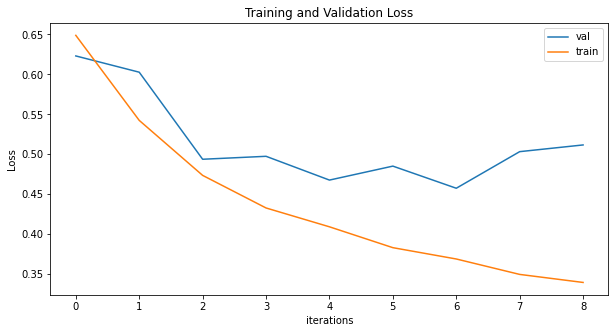

In [26]:
plot_losses(train_losses, val_losses)